<a href="https://colab.research.google.com/github/gohzhihwee/stuffs/blob/main/stats_models_for_finance_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install if libs not yet installed
! pip install arch
! pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=a99f95e1bfaa386931a828cb8a2c5b4901b4ac7ca2a5158ff3c27b1ac5559fca
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
# Importing Python libraries
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
import scipy.stats as stats
import pylab
from arch.unitroot import ADF
from arch.unitroot.cointegration import phillips_ouliaris
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ardl import UECM
from scipy.stats import kurtosis
from scipy.stats import skewnorm
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# **Concept 1: Multicollinearity**

# **Definition**

A phenomenon in which multiple variables in a modelling scenario (> 2) are linearly correlated to each other.

# **Description**

In a complex modelling scenario with numerous variables, the assumption that the variables are independent of each other aside from being correlated to the target (independent) variable does not necessarily hold true. The measured variables contributing to the target value can be correlated to each other as well, making for a more complex system of equations that one needs to consider when modelling such a scenario.

There isn't a single equation to specifically calculate multicollinearity in regression analysis. One of the most commonly used approaches to measure multicollinearity is calculating the Variance Inflation Factor (VIF) for each independent variable in the model using the formula

$VIF_i=\frac{1}{1-{R_i}^2}$

where ${R_i}^2$ is the unadjusted coefficient of determination for regressing the ith independent variable on the remaining ones. If

  \begin{equation}
    VIF_i=
    \begin{cases}
      1, & \text{variables are uncorrelated} \\
      ∈(1,5), & \text{variables are moderately correlated} \\
      5, & \text{variables are highly correlated}
    \end{cases}
  \end{equation}

# **Demonstration**

We repurpose for this demonstration our dataset containing a compilation of historical returns on US T-bills, S&P 500 securities, AAA-rated bonds and several other types of securities, curated by the NYU Stern School of Business (NYU Stern School of Business, 2024) and based off of historical FRED records.

In [ ]:
# In GWP1, we generated a correlation matrix using the Historical
# US 10-Year T-Bond Annual Returns and the S&P 500 Daily Returns from the years 1928-2023.
# We repurpose it here to demonstrate a test for multicollinearity in the data
# The following dataset was curated by NYU Stern School of Business
dataset  = pd.read_csv('histretSP_rawreturnsdata.csv').dropna()
print(dataset)

data = dataset[
    [
       "S&P 500",
       "Dividends",
       "Dividend Yield",
       "T.Bond rate",
       "Return on bond",
       "Aaa Bond Rate",
       "Baa Bond Rate",
       "Returns on Real Estate"
    ]
]
for col in data.columns:
  # print(str(data[col]))
  if '%' in str(data[col]):
    data[col] = data[col].str.rstrip('%').astype('float') / 100
  else:
    data[col] = data[col].astype('float')


cor = data.corr() # Don't specify the method, we just want the correlation matrix

    Year  S&P 500  Dividends Dividend Yield T.Bond rate Return on bond  \
1   1928    24.35       1.05          4.30%       3.45%          0.84%   
2   1929    21.45       0.88          4.10%       3.36%          4.20%   
3   1930    15.34       0.72          4.70%       3.22%          4.54%   
4   1931     8.12       0.50          6.10%       3.93%         -2.56%   
5   1932     6.92       0.50          7.20%       3.35%          8.79%   
..   ...      ...        ...            ...         ...            ...   
92  2019  3230.78      58.50          1.81%       1.92%          9.64%   
93  2020  3756.07      57.00          1.52%       0.93%         11.33%   
94  2021  4766.18      59.20          1.24%       1.51%         -4.42%   
95  2022  3839.50      66.98          1.74%       3.88%        -17.83%   
96  2023  4769.80      70.30          1.47%       3.88%          3.88%   

   Aaa Bond Rate Return on Aaa  Baa Bond Rate Return on Baa   \
1          4.61%          3.28%         5.60%  

<ipython-input-3-2584156434d7>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype('float')
<ipython-input-3-2584156434d7>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype('float')
<ipython-input-3-2584156434d7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

# **Diagram**

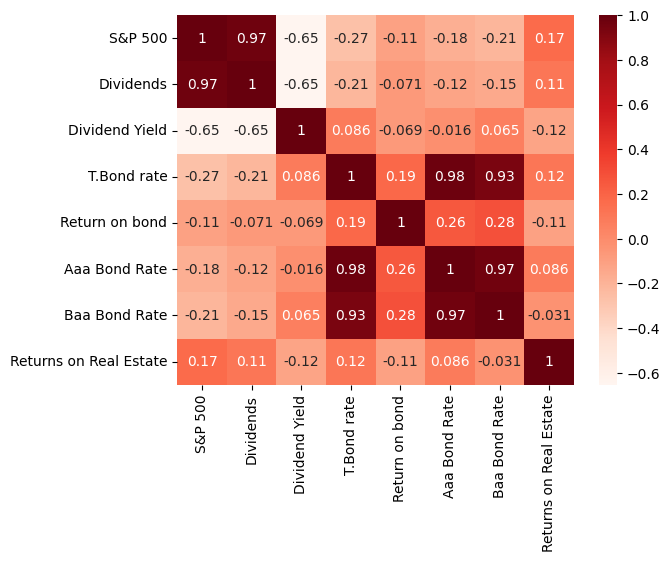

In [ ]:
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds) # Generate the correlation matrix with annotations
plt.show()

We clearly see that multiple nontrivial correlations (> =0.5) relate more than 2 variables in this dataset, e.g. between AAA bond rate, BAA bond rate, S&P 500 and Dividends, to name a few. This tells us that the dataset is highly intercorrelated; multiple linear correlations (likely non-monotonic in nature) and hence multicollinearity exists linking the securities covered in the historical records.

# **Diagnosis**

Can be diagnosed through generating a correlation matrix of the variables involved (see above demonstration and diagram). Within the correlation matrix, if any correlation coefficient aside from the coefficients relating the independent-dependent variable pair is non-zero, then another variable aside from the independent variable and dependent variable shares a correlation outside of the main linear relationship to be modelled. Collinearity thus exists in the data reflecting the modelling scenario.

# **Damage**

When multicollinearity exists, the analyst cannot plot a linear regression between a pair of variables without considering the other correlations and expect to get an accurate/reliable result. Steps have to be taken to either take the other correlations into consideration, or drop the variables that affect the linear regression between the independent and measured variable.

# **Directions**

Several possible strategies – the analyst can opt to drop the independent variables responsible for the multicollinearity, although care must be taken to ensure that the dropped variables do not have linear relationships with either the independent or dependent variable to be modelled by linear regression – if they do, then another method must be used. In which case, one can opt to assess if (any of) the variables causing the multicollinearity can be explained by a set of independent variables. This can be achieved by running linear regressions on said variable with the other independent variables and calculating either the $R^2$ or adjusted $R^2$ metric, then calculating the Variance Inflation Factor (VIF).  If VIF = 1, no multicollinearity exists in the set of variables used in the linear regression model and hence this model will produce reliable results.

# **Concept 2: Joining Time Series with Different Frequencies**

# **Definition**

This refers to a data preprocessing technique known as cointegration. Cointegration involves combining two curves (composed of two separate streams of time-series data) linearly to produce just one curve. In this case, the two curves are generated by time series data of different frequencies and hence the shape of the two curves would be different.

# **Description**

To meaningfully cointegrate two separate time series, it must be possible to linearly combine the two series in such a way that the linear relationship is stationary. Each series of data, however, must be non-stationary. When cointegrating, the difference in frequencies between the two series must be processed via a function that relates the two frequencies to each other; this function must be stationary in nature.

# **Demonstration**

For this demonstration, we successfully cointegrate the time series formed by the monthly closing prices of Apple (AAPL) (Yahoo, 2024) and Amazon (AMZN) stocks (Yahoo, 2024) from the dates Jan 01, 2016 to Dec 31, 2021.

In [ ]:
# For this demo we combine historical Apple and Amazon monthly closing prices from Jan 01, 2016 to Dec 31, 2021
aapl_data = pd.read_csv("AAPL.csv")
amzn_data = pd.read_csv("AMZN.csv")

# **Diagram**

We first verify that the two series and their difference are continuous for the duration being analyzed (2016-2021). We do so by plotting the time series:

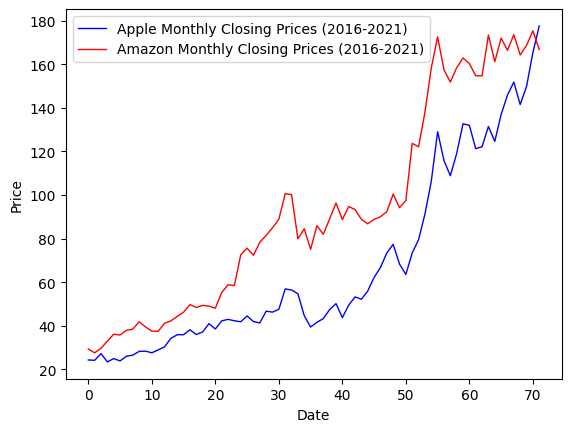

In [ ]:
  # Plot the data
  plt.plot(aapl_data['Close'], linewidth=1, c="b", label="Apple Monthly Closing Prices (2016-2021)")
  plt.plot(amzn_data['Close'], linewidth=1, c="r", label="Amazon Monthly Closing Prices (2016-2021)")
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend()
  plt.show()

The x-axis represents the month count (e.g. 10 represents the 10th month where the 0th month is January 2016, so November 2016) while the y-axis represents the closing price. Using the same axes, we can also represent the difference between the two time series.

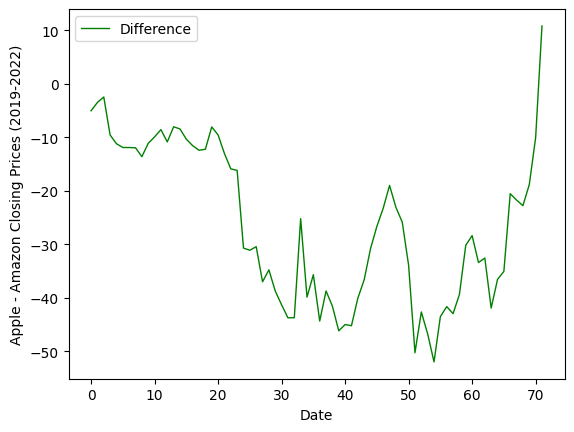

In [ ]:
# Plot the difference between AAPL and AMZN Closing Prices
plt.plot(aapl_data['Close'] - amzn_data['Close'], linewidth=1, c="g", label="Difference")
plt.xlabel("Date")
plt.ylabel("Apple - Amazon Closing Prices (2019-2022)")
plt.legend()
plt.show()

We recall the first criterion for two series to be cointegrated, which is that both series must themselves be non-stationary. Let us use the Engle-Granger Two-Step procedure to systematically test for the potential of AAPL and AMZN’s monthly closes to be cointegrated. Our first step in this procedure is to use the Augmented Dickey-Fuller (ADF) test on our time series to assess their stationarity. We perform the ADF tests on both AAPL and AMZN closing prices, as well as the first differences in their closing prices, at the 5% significance level (i.e. p-value < 0.05).

In [ ]:
# First perform the Augmented Dickey-Fuller (ADF) Test on each of the curves as well as the first difference
# to check for stationarity of all the data to be used
gdp_adf = ADF(aapl_data['Close'], trend="n", method="bic")
hp_adf = ADF(amzn_data['Close'], trend="n", method="bic")
gdp_adf_diff = ADF(aapl_data['Close'].diff().fillna(0), trend="n", method="bic")
hp_adf_diff = ADF(amzn_data['Close'].diff().fillna(0), trend="n", method="bic")

# Print the ADF Test summaries and results
print("Apple Closes Augmented Dickey-Fuller Unit Root Test\n", gdp_adf.regression.summary())
print("\nTest statistics and critical values: \n", gdp_adf.summary())
print("Amazon Closes Augmented Dickey-Fuller Unit Root Test\n", hp_adf.regression.summary())
print("\nTest statistics and critical values: \n", hp_adf.summary())
print("Apple Closes First Difference Augmented Dickey-Fuller Unit Root Test\n", gdp_adf_diff.regression.summary())
print("\nTest statistics and critical values: \n", gdp_adf_diff.summary())
print("Amazon Closes First Difference Augmented Dickey-Fuller Unit Root Test\n", hp_adf_diff.regression.summary())
print("\nTest statistics and critical values: \n", hp_adf_diff.summary())

Apple Closes Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.249
Model:                            OLS   Adj. R-squared (uncentered):              0.215
Method:                 Least Squares   F-statistic:                              7.301
Date:                Mon, 17 Jun 2024   Prob (F-statistic):                    0.000267
Time:                        13:30:21   Log-Likelihood:                         -221.79
No. Observations:                  69   AIC:                                      449.6
Df Residuals:                      66   BIC:                                      456.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025 

We find that, like AAPL Closes, while AMZN monthly closing prices form a non-stationary time series, its first differences form a stationary time series. Were we seeking to find a stationary time series associated with either AAPL and AMZN stocks to analyze, we would be able to use their first difference series. However, for this demonstration, our objective is to conduct and show a test for cointegration of AAPL and AMZN monthly closes. Hence, we will proceed to continue carrying out this aim with the AAPL and AMZN monthly closes.
Our test for cointegration is the Phillips-Ouliaris Test and is the second step of our Engle-Granger Two-Step procedure, conducted at the 5% significance level. Below we programmatically implement it and display its results.


In [ ]:
# Finally, perform the EG Two-Step Residual Based Test for Cointegration of AAPL Data and AMZN Data
aapl_data_cpy = aapl_data.copy().reset_index()
amzn_data_cpy = amzn_data.copy().reset_index()
phillips_ouliaris(aapl_data_cpy['Close'], amzn_data_cpy['Close'], trend="c", test_type="Za", kernel="bartlett")

Test Statistic,-0.521
P-value,0.810
Kernel,Bartlett
Bandwidth,1.989


In this case, our p-value is 0.810, which is greater than 0.05. Hence, we cannot reject the null hypothesis and thus, in this case, AAPL and AMZN monthly closes are not cointegrated. However, this is unlikely to pose a grave challenge to us if our objective is to analyze historical AAPL and AMZN price movements as we discovered earlier that their first differences were stationary time series we can model using established techniques.

# **Diagnosis**

Cointegration is successful when the two curves produced by the separate time series can be combined into a continuous single curve.

# **Damage**

Rather than being harmful to modelling, cointegration simplifies the modelling analysis by reducing the number of functions to be analyzed from 2 or more to 1. However, if a stationary relationship that relates the two different frequencies cannot be established between the two time series, it would not be possible to cointegrate them.

# **Directions**

Prior to any attempt to cointegrate two series, a test such as the Engle-Granger Two-Step Procedure (or EG Test), the Phillips-Perron test or the Augmented Dickey-Fuller (ADF) test can be conducted on the two time series. A demonstration of the EG test in Python is shown above.

# **Concept 3: Unit Root Testing**

# **Definition**

This is a test that checks if 1 is a root value of the time series’ characteristic equation/function to assess if the time series is stationary.

# **Description**

For instance, given a function

\begin{align*}
x_t = \alpha_0 + \alpha_1{x_{t-1}} + v_t
\end{align*}

If $|\alpha_1|=1$, a unit root exists and thus the time series is non-stationary. In the context of modelling, this indicates that methods such as parametric regression or neural networks cannot be deployed directly on the time series as the ground truth relationship changes with time. If $|\alpha_1 |>1$, the series is known as explosive, i.e. its value will continue to either increase or decrease, or ‘runaway’ to infinity.

# **Demonstration**

We use historical Apple (AAPL) monthly closing prices from the dates Jan 01, 2016 to Dec 31, 2021 as our base dataset for this demonstration. Our chosen unit root test is the Augmented Dickey-Fuller (ADF) Test.

In [ ]:
# We will use the Augmented Dickey-Fuller (ADF) Test to assess for stationarity in the time series.
# We use Apple Historical Stock Prices from the years 2016-2021 for this demonstration

apple_data = pd.read_csv("AAPL.csv")
aapl = apple_data.loc[:, ["Date", "Close"]]

# **Diagram**

To verify that the series is continuous in nature, we first plot it for visualization.

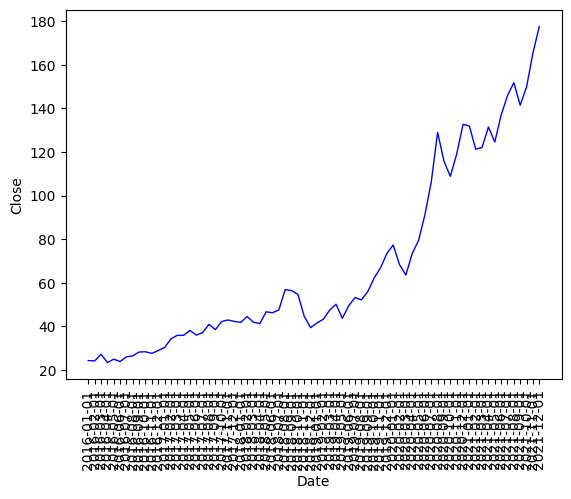

In [ ]:
# Plot the data to visualize it
plt.plot(aapl.Date, aapl.Close, linewidth=1, c="b")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

In this case, our x-axis represents the month in date form and our y-axis represents the closing price.

Having previously conducted a unit root test, the Augmented Dickey-Fuller (ADF) Test on this very dataset to assess its stationarity, we may repurpose it for this demonstration below:

In [ ]:
# AAPL Stock Price, ADF Test without Drift and Trend
adf_none = ADF(aapl["Close"], trend="n", method="bic")
print("AAPL Augmented Dickey-Fuller Unit Root Test\n", adf_none.regression.summary())
print("\nTest statistics and critical values: \n", adf_none.summary())

AAPL Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.249
Model:                            OLS   Adj. R-squared (uncentered):              0.215
Method:                 Least Squares   F-statistic:                              7.301
Date:                Mon, 17 Jun 2024   Prob (F-statistic):                    0.000267
Time:                        13:30:26   Log-Likelihood:                         -221.79
No. Observations:                  69   AIC:                                      449.6
Df Residuals:                      66   BIC:                                      456.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.9

From which we can see that our p-value is 1.000, which is greater than the maximum threshold of 0.05 required to conclude at the 5% significance level that the process is weakly stationary. Hence, the time series comprising AAPL monthly closes contains a unit root and is therefore non-stationary.

# **Diagnosis**

Several methods can be used to detect the presence of a unit root – among the most well-known methods are the Dickey-Fuller test, Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. A combination of the tests can be run – if either the ADF test does not reject the null hypothesis that the time series is stationary, or both the ADF and KPSS tests do not reject the null hypothesis, then a unit root exists and therefore the time series is stationary. Note that a time series can fluctuate along a specific trend (that can be described by a function), in which case it is known as trend-stationary. For trend-stationary data, applying methods such as seasonal decomposition (decomposing the curve into its constituent functions) can also simplify the preprocessing of the time series. The trend-stationary nature of data can be inferred through conducting a combination of the ADF and KPSS tests - if ADF rejects the null hypothesis that the time series is stationary while the KPSS test does not, then the data is trend-stationary.

# **Damage**

Checking for stationarity of the time series is important when deciding on a regression or modelling method to deploy on the time series. If data is non-stationary, parametric regressions that presume a stationary relationship between variables producing the data (e.g. OLS, WLS, Ridge and LASSO regression) cannot be used directly. A failure to check for stationarity using unit root testing could result in the wrong model being deployed, leading to invalid training and testing results.

# **Directions**

If the time series is non-stationary in nature, additional pre-processing of the time series is required such that only stationary components are used. Otherwise, either regime change models or non-parametric regressions must be used; the data can no longer be treated as a whole, but must be broken up into stationary segments to be analyzed. Regime change models are defined and described in the next section.

# **Concept 4: Regime Change Models**

# **Definition**

This refers to a category of machine learning models that process non-stationary time series by splitting them across time periods to create separate temporal regimes, e.g. data when time $t<t_1$, data when time $t_1\leq{t}\leq{t_2}$ and data when time $t>t_2$.

# **Description**

Regime change models split non-stationary time series into separate temporal regimes, each characterized by either a different function or probability distribution. They are meant to handle time series which undergo fundamental changes in their characteristic equations or distributions with time; it is otherwise impossible to accurately model such time series by using parametric regressions that assume a stationary characteristic function describes the time series. Three well-known types of regime change models are threshold-based models (they split data according to variable value thresholds), predictive models (these can be ensembles of models that comprise of a model making an initial prediction of a volatility index or constant of the time series, which is then used in subsequent regression models) or state-space based models such as the Markov-switching Autoregressive Model or Kalman Filter. A state space is a mathematical model of a system that is represented by a transition between a set of stages/phases based on input and output variables, subject to specific criteria (can be thought of as a block diagram where the states are the blocks and one block is connected to another block by an arrow, which represents the output from the previous block being fed as input into the current block). A state space model can also be used to interpolate/forecast missing values in a dataset.

# **Demonstration**

We will be demonstrating an application of the Kalman filter (FilterPy, 2024) for this concept.

We first initialize some necessary information to set up our filter. The following are our starting parameters:

In [ ]:
# For this challenge we demonstrate use of the Kalman Filter
# First, instantiate the filter
kf = KalmanFilter(dim_x=2, dim_z=1)
# Create a sample dataset as well as an array to house the state transitions
kf.x = np.array([2.0, 1.0]) # Initial (starting) position - we use the origin
kf.F = np.array([[1, 1], [0, 1]]) # State transition matrix - only 2 states in this example
kf.H = np.array([[2, 1]]) # Measurement matrix. This matrix links the current position kf.x to the system state kf.F
kf.P *= 10.0 # Estimate error (P contains an identity matrix, so this produces np.array([[10., 0.], [0., 10.]]))
kf.R = 1.0 # Measurement noise
kf.Q = Q_discrete_white_noise(dim=2, dt=1, var=0.1) # Additional Gaussian (white) noise
print(f"Initial Position: {kf.x}")
print(f"Initial State Transition Matrix: \n{kf.F}")
print(f"Initial Measurement Matrix: \n{kf.H}")
print(f"Initial Estimate Error: \n{kf.P}")
print(f"Measurement Noise: {kf.R}")
print(f"White Noise: {kf.Q}")

Initial Position: [2. 1.]
Initial State Transition Matrix: 
[[1 1]
 [0 1]]
Initial Measurement Matrix: 
[[2 1]]
Initial Estimate Error: 
[[10.  0.]
 [ 0. 10.]]
Measurement Noise: 1.0
White Noise: [[0.025 0.05 ]
 [0.05  0.1  ]]


Our system has only 2 transition states, with white noise and error being introduced at each stage. As an example, a derivation of the updated position coordinates after the first iteration is provided in the Word edition of this guidebook.

# **Diagram**

In [ ]:
# Let's run this for 10 rounds - print the output kf.x
ctr = 0
while ctr < 10:
  kf.predict()
  print(f"Noise introduced: {kf.Q}")
  print(f"Coordinates after prediction #{ctr+1}: {kf.x}")
  kf.update(kf.x[0], kf.R, kf.H)
  # kf.update(kf.x[1], kf.R, kf.H)
  print(f"Coordinates after update iteration #{ctr+1}: {kf.x}")
  ctr += 1

Noise introduced: [[0.025 0.05 ]
 [0.05  0.1  ]]
Coordinates after prediction #1: [3. 1.]
Coordinates after update iteration #1: [1.47488584 0.08066971]
Noise introduced: [[0.025 0.05 ]
 [0.05  0.1  ]]
Coordinates after prediction #2: [1.55555556 0.08066971]
Coordinates after update iteration #2: [ 1.13490427 -0.61165512]
Noise introduced: [[0.025 0.05 ]
 [0.05  0.1  ]]
Coordinates after prediction #3: [ 0.52324916 -0.61165512]
Coordinates after update iteration #3: [ 0.54841831 -0.58924793]
Noise introduced: [[0.025 0.05 ]
 [0.05  0.1  ]]
Coordinates after prediction #4: [-0.04082962 -0.58924793]
Coordinates after update iteration #4: [ 0.13035441 -0.46728447]
Noise introduced: [[0.025 0.05 ]
 [0.05  0.1  ]]
Coordinates after prediction #5: [-0.33693006 -0.46728447]
Coordinates after update iteration #5: [-0.12833101 -0.32350894]
Noise introduced: [[0.025 0.05 ]
 [0.05  0.1  ]]
Coordinates after prediction #6: [-0.45183995 -0.32350894]
Coordinates after update iteration #6: [-0.254649

# **Diagnosis**

Regime change models are characterized by their stage or phase-based handling of time series, using a different characteristic function or distribution to model the time series in each phase. Data that is non-stationary and that can be partitioned into phases which can be described by stationary functions is suitable for processing using a regime change model. In the demonstration, we use a Kalman Filter to process a non-stationary time series.

# **Damage**

Care should be taken when analyzing the data to determine the correct category of state space model to use – processing data using a state space model (that splits the data into time regimes) when the data is more appropriately split according to variable thresholds, for instance, could lead to suboptimal results.

# **Directions**

Data should be checked for stationarity using a test such as the unit root test as described in an earlier section. Once it is deemed to be non-stationary, experiment with splitting the data according to thresholds and time; the results of this experiment would then be used to decide on which type of regime change model to use.

# **Concept 5: Feature Extraction**

# **Definition**

This refers to isolating important variables (independent or latent/underlying) that completely account for/explain the variation of values in time series data.

# **Description**

Real-world time series often consist of many variables, to the point that observed variables only form a small subset of the underlying variables that explain variations in the data. However, it is impractical to consider all possible variables when modelling such data as the characteristic equation would be extremely complex, with a high dimensionality. Training a model on such data thus carries a high likelihood of resulting in underfitting. Feature extraction is characterized by reducing the set of variables to a small set of variables that explain most of the variation in the data; this small set of variables can then be used for training, reducing model complexity and hence the likelihood of underfitting, which produces unreliable results. Simultaneously, if the data suffers from multicollinearity, feature extraction can also serve as a means by which to select independent variables (refer back to the problem of multicollinearity, described in an earlier section).

# **Demonstration**

We will demonstrate Principal Component Analysis (PCA) on our multivariate compilation of historical returns on the S&P 500, Dividend Yields, US Treasury Bill rates and other significant US securities, as used earlier in our demonstration of multicollinearity.

In [ ]:
# Feature Extraction - for this example we revert to Principal Component Analysis (PCA)
# We use the dataset containing Historical US 10-Year T-Bond Annual Returns and the S&P 500 Daily Returns from the years 1928-2023
dataset  = pd.read_csv('histretSP_rawreturnsdata.csv').dropna()
cols = [
       "S&P 500",
       "Dividends",
       "Dividend Yield",
       "T.Bond rate",
       "Return on bond",
       "Aaa Bond Rate",
       "Baa Bond Rate",
       "Returns on Real Estate"
]
# Let's select a number of components equal to the number of columns in the dataset (in this case 10)
data = dataset[cols]
for col in data.columns:
  if '%' in str(data[col]):
    data[col] = data[col].str.rstrip('%').astype('float') / 100
  else:
    data[col] = data[col].astype('float')
pca_data = preprocessing.scale(data)
pca = PCA(n_components=len(cols))
pca.fit(pca_data)

<ipython-input-15-23711323ff9c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype('float')
<ipython-input-15-23711323ff9c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype('float')
<ipython-input-15-23711323ff9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

PCA(n_components=8)

# **Diagram**

The analyst has the leeway to decide on the number of principal components, i.e. latent underlying variables composed by a combination of the known parameters in the dataset, to select from when choosing to reduce the number of parameters by which to model data on. For our example, we choose to create 8 different principal components. Below we display the 8 principal components, ordered by proportion of the variance they contribute.

In [ ]:
# Get the proportions of variance and cumulative proportions of variance
variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ind = ["Proportion of Variance", "Cumulative Proportion of Variance"]
columns = [f"PC{i}" for i in range(1, len(cols)+1)]
df = pd.DataFrame(np.vstack((variance, cumulative_variance)), ind, columns=columns)
df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Proportion of Variance,0.41063,0.289604,0.135891,0.101934,0.052294,0.006042,0.002991,0.000613
Cumulative Proportion of Variance,0.41063,0.700234,0.836125,0.938059,0.990354,0.996396,0.999387,1.000000


Following which we display the percentage each known dataset parameter (in this case, each type of US security) contributes to each principal component:

In [ ]:
# Loadings of the Principal Components
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, index=cols, columns=columns)
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
S&P 500,-0.345781,0.481324,0.008519,0.099117,0.346078,-0.023624,0.714523,0.089413
Dividends,-0.316692,0.499696,0.064253,0.139044,0.379710,-0.069838,-0.683089,-0.104309
Dividend Yield,0.213674,-0.479693,-0.149303,0.065089,0.831230,-0.052656,0.007085,0.062808
T.Bond rate,0.492732,0.256173,-0.137814,0.108640,-0.013065,-0.618477,0.103055,-0.517194
Return on bond,0.174610,0.101930,0.639452,-0.715212,0.182120,-0.067653,0.019921,-0.023517
Aaa Bond Rate,0.476631,0.321265,-0.053292,0.093286,-0.021928,-0.137608,-0.091339,0.793921
Baa Bond Rate,0.483123,0.278389,0.038148,0.155765,0.099966,0.757320,0.035899,-0.280282
Returns on Real Estate,-0.025032,0.178324,-0.735745,-0.640554,0.035991,0.110596,-0.046331,-0.016420


From which we note that Treasury bond rates, BAA bond rates, S&P500 and S&P500 Dividends are the parameters contributing the greatest proportions of the variance to each principal component. It would hence be sensible for us to reduce our model parameters to these parameters were we seeking to reduce model dimensionality.

We can perform OLS regression using two of our extracted features to assess the strength of their linear correlation – in this case, we perform this with Treasury bond rates and BAA bond rates, as shown below:

In [ ]:
# Using the insights gathered from the loadings df to perform OLS regression
X = data["S&P 500"]
Y = data["Baa Bond Rate"]
data_ols = pd.DataFrame({'x':X, 'y':Y})
model = smf.ols("y ~ x", data=data_ols)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.393
Date:                Mon, 17 Jun 2024   Prob (F-statistic):             0.0388
Time:                        13:30:27   Log-Likelihood:                 205.31
No. Observations:                  96   AIC:                            -406.6
Df Residuals:                      94   BIC:                            -401.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0720      0.003     20.846      0.0

The low adjusted R-squared value of our model tells us that Treasury bond rate changes and BAA bond rate changes are virtually independent of each other, making them suitable separate parameters to use in modelling a third security that is not strongly correlated to either of them.

# **Diagnosis**

Data that consists of many variables (a dataset with e.g. > 50 columns to be used) can be preprocessed using a feature extraction method.

# **Damage**

Neglecting to preprocess data using feature extraction will undermine the accuracy of model results. Feature extraction not only helps reduce model complexity and hence the probability of overfitting; if done correctly, issues of multicollinearity can also be mitigated with the reduced set of features.

# **Directions**

High-dimensionality data should first be pre-processed using a feature extraction method; in the demonstration above, we revert to the classic transformation of Principal Component Analysis (PCA) to select a limited number of features which best explain variations in our time series. Once the variables have been identified, the analyst can then proceed to use a regression method or an alternative suitable method depending on the nature of the data (stationary/non-stationary; conduct further tests such as the unit root test to verify this). PCA will not affect other properties of the data such as its stationarity; in the case of non-stationary data, parametric regression methods should not be used; instead, a class of regime change models, e.g. state space models, should be considered.

# **References**

FilterPy. (2024, June 1). KalmanFilter. Retrieved from FilterPy documentation: https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html?highlight=get_sensor_reading#kalmanfilter

NYU Stern School of Business. (2024, May 27). Annual Returns on Stock, T.Bonds and T.Bills: 1928 - Current. Retrieved from NYU Stern School of Business: https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSPX.html

Srivastava, S. (2020, June 14). Regime Shift Models – A Fascinating Use Case of Time Series Modeling. Retrieved from Analytics Vidhya: https://www.analyticsvidhya.com/blog/2019/10/regime-shift-models-time-series-modeling-financial-markets/

Yahoo. (2024, June 1). AAPL. Retrieved from Yahoo Finance: https://finance.yahoo.com/quote/AAPL/history/?period1=1451606400&period2=1640908800&interval=1mo&filter=history&frequency=1mo

Yahoo. (2024, June 1). AMZN. Retrieved from Yahoo Finance: https://finance.yahoo.com/quote/AMZN/history/?frequency=1mo

